In [68]:
import PyPDF2
import nltk
import spacy
#nltk.download('stopwords')
from nltk.corpus import stopwords, wordnet
import string
import re

In [72]:
# relevant functions
def extract_text_from_pdf(pdf_path):
    """
    This function extracts text from a pdf doc into a single stream of text.
    """
    text = ""
    with open(pdf_path, "rb") as pdf_file:
        pdf_reader = PyPDF2.PdfReader(pdf_file)
        for page_num in range(len(pdf_reader.pages)):
            page = pdf_reader.pages[page_num]
            text += page.extract_text()
    return text

def preprocess_text(text: str):
    """
    This function pre-processes the text into a useful format for ML algorithms.
    """
    singles_removed = re.sub(r'\s+[a-zA-Z]\s', ' ', text) # remove single characters
    tokens = nltk.word_tokenize(singles_removed) # text tokenisation
    clean_tokens = [token.lower() for token in tokens if token.isalnum()] # remove non-alphanumeric tokens + lowercase
    stop_all = stopwords.words('english') + list(string.punctuation) # define stopwords
    stop_removal = [stop for stop in clean_tokens if stop not in stop_all] # remove stopwords
    pos_tokens = nltk.pos_tag(stop_removal)

    # word lemmatisation
    def get_wordnet_pos(treebank_tag):
        """
        Map POS tag to first character used by WordNetLemmatizer.
        """
        if treebank_tag.startswith('A'):
            return wordnet.ADJ
        elif treebank_tag.startswith('V'):
            return wordnet.VERB
        elif treebank_tag.startswith('N'):
            return wordnet.NOUN
        elif treebank_tag.startswith('R'):
            return wordnet.ADV
        else:
            return wordnet.NOUN  # noun if POS tag is not recognized

    lemmatizer = nltk.stem.WordNetLemmatizer()
    stems = []
    for t in pos_tokens:
        word = t[0]
        pos_type = t[1] # access grammar type
        wordnet_pos = get_wordnet_pos(pos_type)
        stems.append(lemmatizer.lemmatize(t[0], pos = wordnet_pos)) # access word and stem
    
    return stop_removal, stems, pos_tokens

def word_frequency_dist(tokens: list):
    """This function shows the frequency distribution of the top 30 most common words in the text."""
    fdist = nltk.FreqDist(tokens)
    return fdist.plot(30, cumulative = False)


In [73]:
SNOW = extract_text_from_pdf("Data/SNOW_Q224.pdf")
removed_stopwords, word_stems, pos_tags = preprocess_text(SNOW)

In [74]:
print(removed_stopwords[:5], word_stems[:5], pos_tags[:5])

['corrected', 'transcript', 'total', 'pages', '22'] ['correct', 'transcript', 'total', 'page', '22'] [('corrected', 'VBN'), ('transcript', 'NN'), ('total', 'JJ'), ('pages', 'NNS'), ('22', 'CD')]


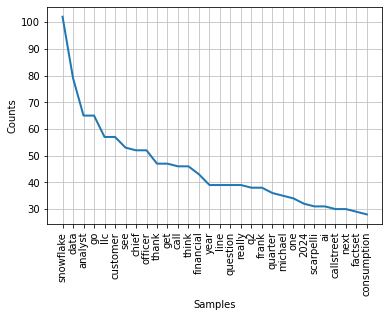

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [75]:
word_frequency_dist(word_stems)